In [5]:
from datetime import date, timedelta, datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import Price_Models as pm
import Data
import time

# Set to true to update database from online data, if false will pull data from csv files
Update = False 
trade_days = 256
est_price_path = './Data/est_prices.csv'

#-- Desired interval examined --
start_date = date(2018,11,7)
end_date = date(2023,11,16)
df_end = end_date + timedelta(days=1) #Add one day as yf functions don't include last day

# Importing data
df = Data.GetData(start_date, df_end, trade_days, Update)
df = df.sample(5000)  #Reduce data size for testing purposes

r = 0.0553

# Uncomment to select only one stock
# stock = '^SPX'
# df = df[df['symbol'] == stock]


LSMC_est_price = [] 
BIN_est_price = [] 
BS_est_price = [] 
MJD_est_price = []

#Duration of calculations
LSMC_time = []
BIN_time = []
BS_time = []
MJD_time = []

# iterates through every option in option chain given a certain stock 
for i in tqdm(range(len(df))):
    S0 = df.iloc[i].S0       # Sets S0
    K = df.iloc[i].strike
    T = df.iloc[i].maturity / 365
    sigma = df.iloc[i].sigma
    type = df.iloc[i].optionType


    if df.iloc[i].method == 'A':
        st = time.time()
        computed_price_LSMC = pm.LSMC(S0, K, T, sigma, r, type)
        et = time.time()
        LSMC_time.append(et-st)
        st = time.time()
        computed_price_BIN = pm.BinomialTree(S0, K, T, sigma, r, type)
        et = time.time()
        BIN_time.append(et-st)
        computed_price_BS = np.nan
        computed_price_MJD = np.nan
    elif df.iloc[i].method == 'E':
        computed_price_LSMC = np.nan
        computed_price_BIN = np.nan   
        st = time.time()
        computed_price_BS = pm.BS(S0, K, T, sigma, r, type)
        et = time.time()
        BS_time.append(et-st)
        st = time.time()
        computed_price_MJD = pm.MJD(S0, K, T, sigma, r, type)
        et = time.time()
        MJD_time.append(et-st)
    else:
        raise Exception('Unexpected option method')

    # LSMC_est_price.append(computed_price_LSMC)
    # BIN_est_price.append(computed_price_BIN)
    # BS_est_price.append(computed_price_BS)
    # MJD_est_price.append(computed_price_MJD)

# mkt_price_A = df[df.method == 'A'].lastPrice
# mkt_price_E = df[df.method == 'E'].lastPrice

# LSMC_perc_error = (df.lastPrice - LSMC_est_price)/df.lastPrice
# BIN_perc_error = (df.lastPrice - BIN_est_price)/df.lastPrice
# BS_perc_error = (df.lastPrice - BS_est_price)/df.lastPrice
# MJD_perc_error = (df.lastPrice - MJD_est_price)/df.lastPrice

# df = df.assign(LSMC_est_price = LSMC_est_price)
# df = df.assign(LSMC_perc_error = LSMC_perc_error)
# df = df.assign(BIN_est_price = BIN_est_price)
# df = df.assign(BIN_perc_error = BIN_perc_error)
# df = df.assign(BS_est_price = BS_est_price)
# df = df.assign(BS_perc_error=BS_perc_error)
# df = df.assign(MJD_est_price = MJD_est_price)
# df = df.assign(MJD_perc_error=MJD_perc_error)

LSMC_avg = np.average(LSMC_time)
BIN_avg = np.average(BIN_time)
BS_avg = np.average(BS_time)
MJD_avg = np.average(MJD_time)

# df.to_csv(est_price_path)

100%|██████████| 5000/5000 [02:05<00:00, 39.87it/s]


In [37]:
from sklearn.linear_model import LinearRegression
import scipy

lineplot = lambda x,a,b: a*x+b
expplot = lambda t,a,b,c: a+b*np.exp(c*t)

maturity_A = df[df.method == 'A'].maturity/365
maturity_E = df[df.method == 'E'].maturity/365

model_BIN = scipy.optimize.curve_fit(expplot,  maturity_A,  BIN_time)
model_LSMC = scipy.optimize.curve_fit(lineplot,  maturity_A,  LSMC_time)
#model_LSMC = LinearRegression().fit(maturity_A,LSMC_time)
model_BS = scipy.optimize.curve_fit(lineplot,  maturity_E,  BS_time)
model_MJD = scipy.optimize.curve_fit(lineplot,  maturity_E,  MJD_time)
model_LSMC

(array([ 0.02254714, -0.00010568]),
 array([[ 1.07303678e-08, -7.66982832e-09],
        [-7.66982832e-09,  1.11955982e-08]]))

[[0.025861941014568453, 0.003280221105551131], [0.01923234175269879, -0.0034915711483918966]]


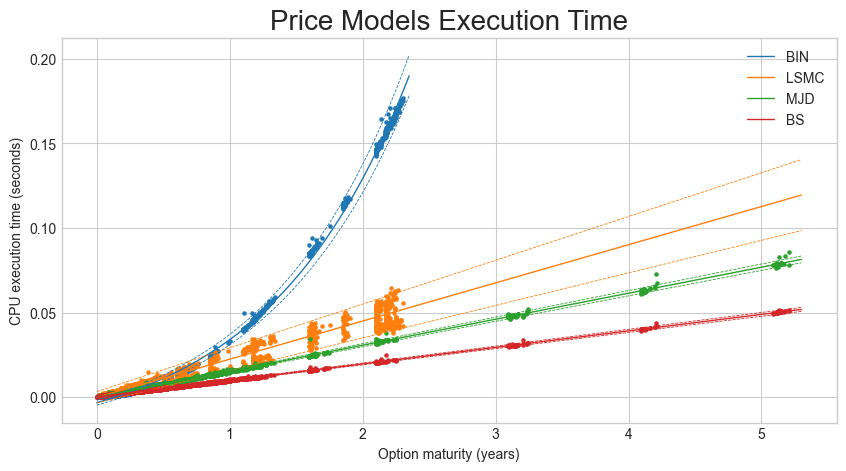

In [74]:
import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi'] = 500
%matplotlib inline
plt.style.use("seaborn-v0_8-whitegrid") 

x1 = np.linspace(0,2.35)
x2 = np.linspace(0,5.3,60)

# LSMC_adj = LSMC_time/(df[df.method == 'A'].maturity/365)
# BIN_adj = BIN_time/(df[df.method == 'A'].maturity/365)
# BS_adj = BS_time/(df[df.method == 'E'].maturity/365)
# MJD_adj = MJD_time/(df[df.method == 'E'].maturity/365)

# plt.plot(x, LSMC_adj)
# plt.plot(x, BIN_adj)
# plt.show()

def CI(model, length):
    Var = []
    coef1 = []
    coef2 = []
    for i in range(length):
        Var.append(model[1][i,i])
        b=2.5
        if length == 2:
            b = 32
        a1 = model[0][i] + b*np.sqrt(Var[i])
        a2 = model[0][i] - b*np.sqrt(Var[i])
        coef1.append(a1)
        coef2.append(a2)
    coef = [coef1,coef2]
    return coef
print(CI(model_LSMC,2))
plt.figure(figsize=(10, 5))
plt.scatter(maturity_A, BIN_time, s=5)
plt.plot(x1, expplot(x1,*model_BIN[0]),linewidth=1, label='BIN', color = 'tab:blue')
plt.plot(x1, expplot(x1,*CI(model_BIN,3)[0]), '--',linewidth=0.6, color = 'tab:blue')
plt.plot(x1, expplot(x1,*CI(model_BIN,3)[1]), '--',linewidth=0.6, color = 'tab:blue')
# plt.show()
plt.scatter(maturity_A, LSMC_time, s=5)
plt.plot(x2, lineplot(x2, *model_LSMC[0]),linewidth=1, label='LSMC', color = 'tab:orange')
plt.plot(x2, lineplot(x2,*CI(model_LSMC,2)[0]), '--',linewidth=0.6, color = 'tab:orange')
plt.plot(x2, lineplot(x2,*CI(model_LSMC,2)[1]), '--',linewidth=0.6, color = 'tab:orange')
# plt.show()
plt.scatter(maturity_E, MJD_time, s=5)
plt.plot(x2, lineplot(x2, *model_MJD[0]), linewidth=1, label='MJD', color = 'tab:green')
plt.plot(x2, lineplot(x2,*CI(model_MJD,2)[0]), '--',linewidth=0.6, color = 'tab:green')
plt.plot(x2, lineplot(x2,*CI(model_MJD,2)[1]), '--',linewidth=0.6, color = 'tab:green')

plt.scatter(maturity_E, BS_time, s=5)
plt.plot(x2, lineplot(x2, *model_BS[0]), linewidth=1, label='BS', color = 'tab:red')
plt.plot(x2, lineplot(x2,*CI(model_BS,2)[0]), '--',linewidth=0.6, color = 'tab:red')
plt.plot(x2, lineplot(x2,*CI(model_BS,2)[1]), '--',linewidth=0.6, color = 'tab:red')

plt.title('Price Models Execution Time', fontsize = 20)
plt.xlabel('Option maturity (years)')
plt.ylabel('CPU execution time (seconds)')
plt.legend()
plt.savefig('./Data/ExecutionTime.png', dpi = 300, transparent = False)
plt.show()
